In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
import torch.optim as optim

In [2]:
import numpy as np
from scipy import linalg as splin

In [3]:
import matplotlib.pyplot as plt
import datetime

from tqdm import trange
from tensorboardX import SummaryWriter

In [4]:
now_str = lambda : str(datetime.datetime.now()).replace(" ", "__")

Modelling $p(x_1, x_2) = \mathcal{N}(x1|\mu=\frac{1}{4}x_2^2, \sigma=1) \cdot N(x_2|\mu=0, \sigma=4)$

In [5]:
def gen_samples(batch_size=512):
    x2_dist = distrib.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample((batch_size,))

    x1 = distrib.Normal(loc=.25 * (x2_samples.pow(2)),
                  scale=torch.ones((batch_size,)))
    
    x1_samples = x1.sample()
    return torch.stack([x1_samples, x2_samples]).t()

x_samples = gen_samples(1024)

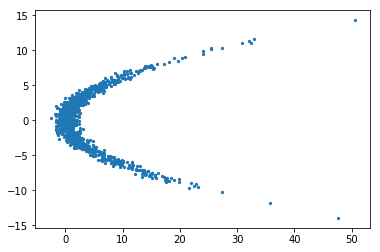

In [6]:
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=5)
plt.show()

In [7]:
base_dist = distrib.Normal(loc=torch.zeros(2), scale=torch.ones(2))

In [8]:
x0_samples = base_dist.sample((1000,))

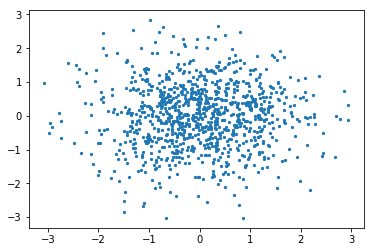

In [9]:
plt.scatter(x0_samples[:, 0], x0_samples[:, 1], s=5)

In [10]:
class Flow(transform.Transform, nn.Module):
    """
    purpose of this class is to make `transform.Transform` 'trainable'
    
    simple flows will inherit it
    """
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
        #self.bijective = True
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

In [11]:
## Affine Flow with LU decomposition
class AffineLUFlow(Flow):
    def __init__(self, dim):
        super(AffineLUFlow, self).__init__()
        weights = torch.Tensor(dim, dim)
        nn.init.orthogonal_(weights)
        # Compute the parametrization
        P, L, U = splin.lu(weights.numpy())
        self.P = torch.Tensor(P)
        self.L = nn.Parameter(torch.Tensor(L))
        self.U = nn.Parameter(torch.Tensor(U))
        # Need to create masks for enforcing triangular matrices
        self.mask_low = torch.tril(torch.ones(weights.size()), -1)
        self.mask_up = torch.triu(torch.ones(weights.size()), -1)
        self.I = torch.eye(weights.size(0))
        # Now compute s
        self.s = nn.Parameter(torch.Tensor(np.diag(U)))
        self.bijective = True

    def _call(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ weights
    
    def _inverse(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ torch.inverse(weights)

    def log_abs_det_jacobian(self, z, y):
        return torch.sum(torch.log(torch.abs(self.s))).unsqueeze(0).repeat(z.size(0), 1)

In [12]:
# Flow version of Leaky ReLU
class PReLUFlow(Flow):
    def __init__(self, dim):
        super(PReLUFlow, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.bijective = True

    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(0.01, 0.99)

    def _call(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)

    def _inverse(self, z):
        return torch.where(z >= 0, z, torch.abs(1. / self.alpha) * z)

    def log_abs_det_jacobian(self, z, y):
        I = torch.ones_like(z)
        J = torch.where(z >= 0, I, self.alpha * I)
        log_abs_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_abs_det, dim = 1)

In [13]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            y = self.bijectors[b](z)
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z, y))
            z = y
        return z, self.log_det

# Our MLP blocks
block_mlp = [
    AffineLUFlow,
    PReLUFlow
]
# Create normalizing flow
flow = NormalizingFlow(dim=2, blocks=block_mlp, flow_length=4, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

In [14]:
#flow = NormalizingFlow(
#    dim=2, 
#    blocks=([AffineLUFlow, PReLUFlow]*5 + [AffineLUFlow]),
#    #blocks=([AffineLUFlow, PReLUFlow, AffineLUFlow]),
#    base_dist=base_dist
#)

In [15]:
# Create optimizer algorithm
opt = optim.Adam(flow.parameters(), lr=1e-2)
# Add learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(opt, 0.9999)

In [16]:
X0 = flow.base_density.sample((1000,)).numpy()

colors = np.zeros(len(X0))

idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
colors[idx] = 0
idx = np.logical_and(X0[:, 0] >= 0, X0[:, 1] < 0)
colors[idx] = 1
idx = np.logical_and(X0[:, 0] >= 0, X0[:, 1] >= 0)
colors[idx] = 2
idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] >= 0)
colors[idx] = 3

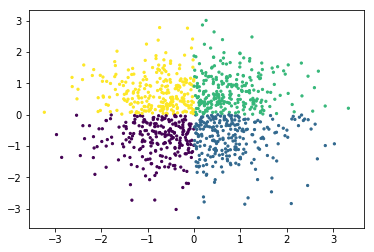

In [17]:
plt.scatter(X0[:, 0], X0[:, 1], s=5, c=colors)

In [83]:
writer = SummaryWriter(f"/workspace/sandbox/tensorboard_logs/{now_str()}")

for it in trange(5000):
    x_samples = gen_samples()

    opt.zero_grad()
    loss = -flow.final_density.log_prob(x_samples).mean()
    loss.backward()
    if it % 50 == 0:
        writer.add_scalar("loss", loss, it)
        
    #if it % 1000 == 0:
    #    writer.add_figure("warp", plot_flow(flow), it)

    opt.step()
    #scheduler.step()



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 5/5000 [00:00<01:45, 47.53it/s]

  0%|          | 10/5000 [00:00<01:47, 46.48it/s]

  0%|          | 15/5000 [00:00<01:49, 45.40it/s]

  0%|          | 20/5000 [00:00<01:50, 45.27it/s]

  0%|          | 25/5000 [00:00<01:51, 44.62it/s]

  1%|          | 29/5000 [00:00<01:55, 42.87it/s]

  1%|          | 33/5000 [00:00<01:58, 41.87it/s]

  1%|          | 37/5000 [00:00<02:10, 38.10it/s]

  1%|          | 42/5000 [00:00<02:02, 40.55it/s]

  1%|          | 47/5000 [00:01<01:55, 42.82it/s]

  1%|          | 52/5000 [00:01<01:52, 44.12it/s]

  1%|          | 59/5000 [00:01<01:40, 49.02it/s]

  1%|▏         | 66/5000 [00:01<01:32, 53.40it/s]

  1%|▏         | 73/5000 [00:01<01:27, 56.43it/s]

  2%|▏         | 79/5000 [00:01<01:27, 56.06it/s]

  2%|▏         | 85/5000 [00:01<01:39, 49.33it/s]

  2%|▏         | 92/5000 [00:01<01:32, 53.05it/s]

  2%|▏         | 98/5000 [00:01<01:29, 54.70it/s]

  2%|▏         | 104/5000 [00:02<01:29,

 32%|███▏      | 1598/5000 [00:32<01:00, 56.16it/s]

 32%|███▏      | 1605/5000 [00:33<01:19, 42.88it/s]

 32%|███▏      | 1611/5000 [00:33<01:14, 45.79it/s]

 32%|███▏      | 1618/5000 [00:33<01:06, 50.80it/s]

 32%|███▎      | 1625/5000 [00:33<01:02, 54.37it/s]

 33%|███▎      | 1632/5000 [00:33<00:58, 57.09it/s]

 33%|███▎      | 1639/5000 [00:33<00:56, 59.92it/s]

 33%|███▎      | 1646/5000 [00:33<00:55, 59.89it/s]

 33%|███▎      | 1653/5000 [00:33<01:01, 54.48it/s]

 33%|███▎      | 1659/5000 [00:34<01:16, 43.61it/s]

 33%|███▎      | 1664/5000 [00:34<01:17, 43.29it/s]

 33%|███▎      | 1669/5000 [00:34<01:15, 44.33it/s]

 33%|███▎      | 1674/5000 [00:34<01:14, 44.55it/s]

 34%|███▎      | 1679/5000 [00:34<01:13, 45.15it/s]

 34%|███▎      | 1684/5000 [00:34<01:12, 45.96it/s]

 34%|███▍      | 1689/5000 [00:34<01:10, 46.75it/s]

 34%|███▍      | 1694/5000 [00:34<01:10, 46.72it/s]

 34%|███▍      | 1699/5000 [00:34<01:10, 46.99it/s]

 34%|███▍      | 1704/5000 [00:35<01:10, 46.91

 62%|██████▏   | 3082/5000 [01:07<00:35, 54.23it/s]

 62%|██████▏   | 3088/5000 [01:07<00:36, 52.42it/s]

 62%|██████▏   | 3095/5000 [01:07<00:34, 54.85it/s]

 62%|██████▏   | 3101/5000 [01:07<00:34, 55.32it/s]

 62%|██████▏   | 3107/5000 [01:07<00:34, 54.27it/s]

 62%|██████▏   | 3113/5000 [01:07<00:37, 50.48it/s]

 62%|██████▏   | 3119/5000 [01:07<00:38, 49.42it/s]

 62%|██████▎   | 3125/5000 [01:07<00:36, 51.21it/s]

 63%|██████▎   | 3132/5000 [01:08<00:34, 54.50it/s]

 63%|██████▎   | 3139/5000 [01:08<00:32, 57.76it/s]

 63%|██████▎   | 3146/5000 [01:08<00:31, 59.50it/s]

 63%|██████▎   | 3153/5000 [01:08<00:31, 58.91it/s]

 63%|██████▎   | 3159/5000 [01:08<00:31, 58.71it/s]

 63%|██████▎   | 3165/5000 [01:08<00:40, 45.60it/s]

 63%|██████▎   | 3171/5000 [01:08<00:42, 43.35it/s]

 64%|██████▎   | 3177/5000 [01:08<00:39, 46.56it/s]

 64%|██████▎   | 3183/5000 [01:09<00:37, 48.26it/s]

 64%|██████▍   | 3189/5000 [01:09<00:36, 49.94it/s]

 64%|██████▍   | 3195/5000 [01:09<00:35, 50.55

 90%|█████████ | 4507/5000 [01:40<00:13, 37.83it/s]

 90%|█████████ | 4511/5000 [01:40<00:13, 35.74it/s]

 90%|█████████ | 4515/5000 [01:40<00:13, 36.12it/s]

 90%|█████████ | 4519/5000 [01:40<00:13, 36.25it/s]

 90%|█████████ | 4523/5000 [01:41<00:13, 34.56it/s]

 91%|█████████ | 4527/5000 [01:41<00:13, 35.62it/s]

 91%|█████████ | 4531/5000 [01:41<00:13, 35.79it/s]

 91%|█████████ | 4535/5000 [01:41<00:13, 34.47it/s]

 91%|█████████ | 4540/5000 [01:41<00:12, 36.06it/s]

 91%|█████████ | 4544/5000 [01:41<00:12, 36.49it/s]

 91%|█████████ | 4548/5000 [01:41<00:12, 35.78it/s]

 91%|█████████ | 4552/5000 [01:41<00:12, 36.24it/s]

 91%|█████████ | 4556/5000 [01:41<00:12, 36.53it/s]

 91%|█████████ | 4560/5000 [01:42<00:12, 36.43it/s]

 91%|█████████▏| 4564/5000 [01:42<00:11, 37.12it/s]

 91%|█████████▏| 4568/5000 [01:42<00:11, 36.72it/s]

 91%|█████████▏| 4573/5000 [01:42<00:11, 37.99it/s]

 92%|█████████▏| 4577/5000 [01:42<00:11, 37.70it/s]

 92%|█████████▏| 4582/5000 [01:42<00:10, 39.26

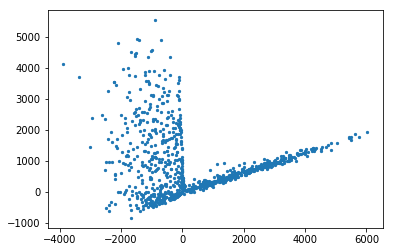

In [86]:
xhat_samples = flow.final_density.sample((1000, ))
plt.scatter(xhat_samples[:, 0], xhat_samples[:, 1], s=5)
#plt.xlim(0, 60)
#plt.ylim(-15, 15)
plt.show()

In [18]:
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [41]:
def nflow_change_density(flow, z):
    # Apply our transform on coordinates
    f_z, log_det = flow(torch.Tensor(z))
    f_z = f_z.detach()
    log_det = log_det[0].detach()
    
    
    q0_density = flow.base_density.log_prob(torch.Tensor(z)).detach().exp()
    
    # Obtain our density
    q1_density = q0_density.squeeze() / np.exp(log_det.squeeze())
    return q1_density, f_z

In [47]:
nflow = NormalizingFlow(
    dim=2, 
    blocks=[PReLUFlow],
    flow_length=1,
    density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
)

#nflow.bijectors[0].weight.data = torch.Tensor([[4, 0]])
#nflow.bijectors[0].scale.data = torch.Tensor([[2, 0]])
nflow.bijectors[0].alpha.data = torch.Tensor([0.3])

q1_density, f_z = nflow_change_density(nflow, z)

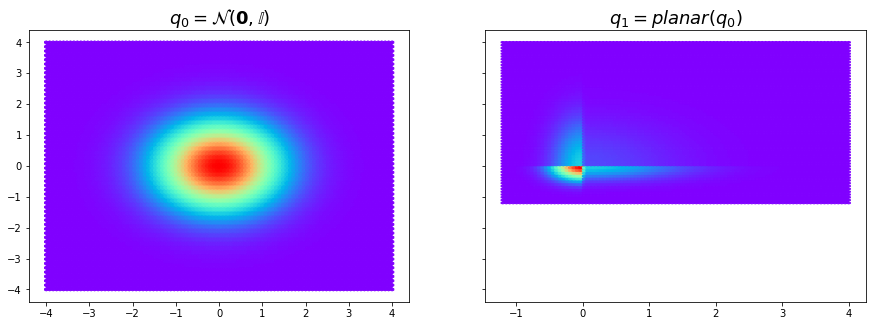

In [48]:
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

Now I want to make sure that `nflow.final_dist` yields the same as above

In [45]:
_, f_z = nflow_change_density(nflow, z)

q1_density = nflow.final_density.log_prob(f_z)

NotImplementedError: 

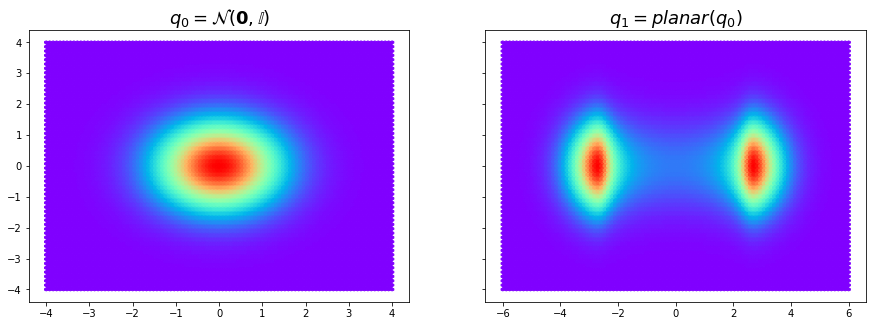

In [25]:
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

In [ ]:
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=flow.final_density, cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);